** Our goal is to create optimal Skoltech schedule. **

Lets use the following notation:
$$ A_{chd} \in \{0,1\},$$ 

where $c = \overline {1 \dots n} \quad$ - the class index, $ h \in \{1, 2, 3\}$ - hour index, and $d \in\{1,2,3, 4\}$ refers to the one of the four studiyng days. Then, the tensor $A_{chd}$ containts information about whether the class $c$ is going to be
taught at hour slot $h$ on the day $d$ ($A_{chd} = 1$) or not ($A_{chd} = 0$).

## Objective
One of the possible ways to model objective of this optimization problem is to make our schedule mor or less uniform:

$$ \min\limits_A \quad \sum\limits_{h = 1}^{3} \sum\limits_{d = 1}^{4}{\Bigl(\sum\limits_{c=1}^{n} A_{chd}\Bigr)}^2 $$



### AND
 we want to have classes at the same our slot during the weekend (Thank you, Anton!):
 $$ p_1\min\limits_A \quad \sum\limits_{c = 1}^{n} \sum\limits_{h = 1}^{3}\sum\limits_{i \ne j} \Bigl|A_{chd_i}- A_{chd_j}\Bigr| $$
 

### AND
 we have professors' preferences:
 $$\min \quad p_2\sum_{c \in C}\sum_{h, d \ne h_p, d_p} A_{chd},$$
 where $C$ is a set of courses that are dependent from professors' preferences  and $p$ is a weight parameter
 
### Also
 we have constraints on not overlapping courses:
 $$ \min p_3\sum_{h, d}{(A_{c_ihd} + A_{c_jhd})}^2,$$
 where $c_i$ and $c_j$ are not overlapping courses
 
 After summarizing all overdescribed, we will get th following objective:
 $$ \min\limits_A \quad \sum\limits_{h = 1}^{3} \sum\limits_{d = 1}^{4}{\Bigl(\sum\limits_{c=1}^{n} A_{chd}\Bigr)}^2
                        +p_1\sum\limits_{c = 1}^{n} \sum\limits_{h = 1}^{3}\sum\limits_{i \ne j} \Bigl|A_{chd_i}- A_{chd_j}\Bigr|
             +p_2\sum_{c \in C}\sum_{h, d \ne h_p, d_p} A_{chd} + p_3\sum_{h, d}{(A_{c_ihd} + A_{c_jhd})}^2$$
## Constraints
Our **Edu** office told us that we have two types of constraints which we should take into consideration:
* The number of classes for each programm  is defined:
$$ \sum\limits_{d ,h} A_{cdh} \ge {\alpha}_c, \quad c = 1 \dots n$$
* We assume, that studients want to attend different classes within one day:
$$ \sum\limits_{h = 1}^{3} A_{chd} \le 1, \quad \forall c, d $$


In [97]:
import numpy as np
import gurobipy as grb
from cvxpy import *

titles=['Intellectual Property and Technological Innovation',
        'Introduction to Composite Materials and Structures',
        'Thermal Fluid Sciences',
        'Petroleum Geophysics',
        'Introduction Device Physics',
        'Materials Chemistry',
        'Mathematical Methods of Optical Communication',
        'Quantum Fluids',
        'Introduction to Power Systems',
        'Bayesian Methods - Adv Machine Learning',
        'Numerical methods for Partial Differential Equations',
        'Bioinformatics Lab Course 2',
        'RNA Biology',
        'Stem Cells',
        'Space Sector Course',
        'Dynamic Systems and Control'
        ]
n = len(titles)
h = 3  # hours slots
d = 4  # number of days
m = d*h

In [98]:
import cvxpy
C = 10
A = Bool(n, m)


######### first type of constraints ##########
alpha = np.array([3, 3, 2, 2, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 2, 2], dtype = int) 
constraints = [sum_entries(A[i,:]) >= alpha[i] for i in range(n)]

##### second type of constrints ###########

for i in xrange(n):
    for j in xrange(0, 12, 3):
        constraints.append(sum_entries(A[i, j:j+3]) <= 1)

######## second type of constraints (Core courses) #########
#for j in range(m):
#    constraints.append(A[2,j] + A[3, j] + A[8, j] <= 1)
   
#for j in range(m):
#    constraints.append(A[2,j] + A[3, j] <= 1)
    
#for j in range(m):
#    constraints.append(A[4,j] + A[6, j] + A[7, j] <= 1)

#for j in range(m):
#    constraints.append(A[3,j] + A[8, j] <= 1)
    
#for j in range(m):
#    constraints.append(A[11,j] + A[12, j] + A[13, j] <= 1)

expr = Constant(0)    
for i in xrange(n):
    for j in xrange(h):
        expr = expr + cvxpy.abs(A[i, j] - A[i, j + 3]) + \
            cvxpy.abs(A[i, j] - A[i, j + 6]) + \
            cvxpy.abs(A[i, j] - A[i, j + 9]) + \
            cvxpy.abs(A[i, j + 3] - A[i, j + 6]) + \
            cvxpy.abs(A[i, j + 3] - A[i, j + 9]) + \
            cvxpy.abs(A[i, j + 6] - A[i, j + 9])
            
            

######## Professors' peferences ##########
##########################################

expr2 = Constant(0)

####### Intro to Comp. mterials and structures, i = 1 ; Adv. ML, i =9 #######
for j in range(m):
    if (j != 4 ) & (j !=  7):
        expr2 += C*(A[1, j] + A[9, j])
        
######## Thermal Fluid Sciences, i = 2 ##################
for j in range(m):
    if (j != 1 ) & (j !=  10):
        expr2 += C*A[2, j]

######## Quantum Fluids, i = 7 #########################
for j in range(m):
    if (j != 1) & (j != 4) & (j != 7) & (j != 10):
        expr2 += C*A[7, j]

        
######## Numerial metods for PDE, i =10 ###############
for j in range(m):
    if (j != 0) & (j != 3) & (j != 6):
        expr2 += C*A[10, j]
        
######## Stem Cells, i = 13 ##################
for j in range(m):
    if (j != 0) & (j != 3) & (j != 6) & (j != 9):
        expr2 += C*A[13, j]
        

######## Not overlapping courses ################
C3 = 100
expr3 = Constant(0)
for j in range(m):
    expr3 += square(A[2, j] + A[3, j] + A[8, j]) + square (A[4, j] + A[6, j] + A[7, j]) + square(A[11, j] + A[12, j] + A[13, j])
        

objective = Minimize(sum_entries(square(sum_entries(A, axis= 0))) + expr + expr2 + expr3)
prob = Problem(objective, constraints)

kwargs = { 'timeLimit': 100 }
prob.solve(solver = 'GUROBI', verbose = True, **kwargs)

Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Changed value of parameter QCPDual to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Changed value of parameter TimeLimit to 100.0
   Prev: 1e+100  Min: 0.0  Max: 1e+100  Default: 1e+100
Optimize a model with 800 rows, 672 columns and 2652 nonzeros
Model has 48 quadratic constraints
Coefficient statistics:
  Matrix range    [1e+00, 2e+00]
  Objective range [1e+00, 1e+01]
  Bounds range    [1e+00, 1e+00]
  RHS range       [1e+00, 3e+00]
Presolve removed 48 rows and 48 columns
Presolve time: 0.08s
Presolved: 752 rows, 624 columns, 2556 nonzeros
Variable types: 384 continuous, 240 integer (192 binary)

Root relaxation: objective -2.500000e+01, 150 iterations, 0.03 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  -25.00000    0    2          -  -25.00000      -     -    0s
     0     0   82.26144    0  

244.99998179409886

In [99]:
import matplotlib.pyplot as plt
%matplotlib inline
B = np.zeros((n, m))
B = np.copy(np.asarray(A.value))
#plt.spy(B, marker = '.')


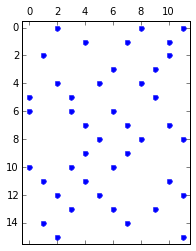

In [100]:
for i in range(n):
    for j in range(m):
        if (B[i,j] < 1e-3):
            B[i, j] = 0
B[1, :]
plt.spy(B, marker = '.')

In [101]:
###### Printing results ######

days = ['Monday', 'Tuesday', 'Thursday', 'Friday']
hours = ['1', '2', '3']
flag = True
schedule = {'Monday': [], 'Tuesday': [], 'Thursday': [], 'Friday': []}

for i in schedule.keys():
    for j in range(h):
        schedule[i].append([])
        
schedule.update({'Wednesday':[['Advanced Molecular Biology Techniques 1'],['Advanced Molecular Biology Techniques 1'],
                  ['Advanced Molecular Biology Techniques 1']]  })


for j in range(m):
    hd = []
    if (j%3 ==0):
        print days[j/3], ':'
        flag = False
    for k in range (n):
        if (B[k, j] == 1):
            hd.append(titles[k])
            schedule[days[j/3]][j%3].append(titles[k])
    print j%3+1, '-', hd

Monday :
1 - ['Materials Chemistry', 'Mathematical Methods of Optical Communication', 'Numerical methods for Partial Differential Equations']
2 - ['Thermal Fluid Sciences', 'Bioinformatics Lab Course 2', 'Space Sector Course']
3 - ['Intellectual Property and Technological Innovation', 'Introduction Device Physics', 'RNA Biology', 'Dynamic Systems and Control']
Tuesday :
1 - ['Materials Chemistry', 'Mathematical Methods of Optical Communication', 'Numerical methods for Partial Differential Equations', 'Stem Cells']
2 - ['Introduction to Composite Materials and Structures', 'Quantum Fluids', 'Bayesian Methods - Adv Machine Learning', 'Bioinformatics Lab Course 2']
3 - ['Introduction Device Physics', 'Introduction to Power Systems', 'RNA Biology']
Thursday :
1 - ['Petroleum Geophysics', 'Mathematical Methods of Optical Communication', 'Numerical methods for Partial Differential Equations', 'Stem Cells']
2 - ['Introduction to Composite Materials and Structures', 'Quantum Fluids', 'Bayesian

In [102]:
schedule


{'Friday': [['Petroleum Geophysics', 'Materials Chemistry', 'Stem Cells'],
  ['Introduction to Composite Materials and Structures',
   'Thermal Fluid Sciences',
   'Quantum Fluids',
   'Bioinformatics Lab Course 2'],
  ['Intellectual Property and Technological Innovation',
   'Introduction to Power Systems',
   'RNA Biology',
   'Dynamic Systems and Control']],
 'Monday': [['Materials Chemistry',
   'Mathematical Methods of Optical Communication',
   'Numerical methods for Partial Differential Equations'],
  ['Thermal Fluid Sciences',
   'Bioinformatics Lab Course 2',
   'Space Sector Course'],
  ['Intellectual Property and Technological Innovation',
   'Introduction Device Physics',
   'RNA Biology',
   'Dynamic Systems and Control']],
 'Thursday': [['Petroleum Geophysics',
   'Mathematical Methods of Optical Communication',
   'Numerical methods for Partial Differential Equations',
   'Stem Cells'],
  ['Introduction to Composite Materials and Structures',
   'Quantum Fluids',
   'Bay

In [103]:
# rooms list
# without '450 Space Lab' because we should only assign space to it
rooms = ['401', '402', '403', '407', '408', '421', '423', '441CL', '404 CL']

# dates for stub
dates = ['Feb 1, 8, 15, 22, 29, March 7', 'Feb 2, 9, 16, March 1', 'Feb 3, 10, 17, 24, March 2, 9',
         'Feb 4, 11, 18, 25, March 3, 10', 'Feb 5, 12, 19, 26, March 4, 11']

days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]

# Improved importing


In [104]:
dotw = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]

In [105]:
-